# Step 5: Feature Engineering for NYC 311 Modeling

This notebook demonstrates the complete feature engineering pipeline for three modeling tracks:
1. **Forecast** - Time-series forecasting of ticket arrivals
2. **Triage** - Ticket prioritization at creation time
3. **Duration** - Survival modeling for time-to-close

All features are **leakage-safe** and use **H3-based spatial grouping**.


In [1]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


from src import preprocessing
from src import features
from src import config
from src import forecast

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

## Usage Instructions

This notebook uses the feature engineering module from `src/features.py`.

To run this notebook:
1. Ensure you have data in `data/landing/311-service-requests/`
2. Run `pip install -r requirements.txt` to install dependencies
3. Execute cells sequentially

For detailed documentation, see `src/FEATURE_ENGINEERING_README.md`


In [2]:
df_orig = preprocessing.preprocess_and_merge_external_data()

Loading DOHMH data...
Data Shape: (1029643, 27)
Preprocessing DOHMH data...
Data Shape: (671735, 44)
Merging census data...
Data Shape: (671735, 48)
Merging weather data...
Data Shape: (657874, 59)

Final Data Shape: (657874, 59)


In [3]:
reload(features)

<module 'src.features' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\features.py'>

In [4]:
df = df_orig.copy()
forecast_panel = features.build_forecast_panel(df)



In [5]:
numerical_columns = [
            'lag1', 'lag4', 'roll4', 'roll12',
            'momentum', 'weeks_since_last',
            'tavg', 'prcp', 'heating_degree', 'cooling_degree',
            'rain_3d', 'rain_7d', 'log_pop', 'nbr_roll4', 'nbr_roll12'
        ]

categorical_columns = ['week_of_year', 'month', 'heat_flag', 'freeze_flag', 'hex6', 'complaint_family']
horizons = [1, 2, 3, 4]

poisson_params = {
            'objective': 'poisson',
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }


tweedie_params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,   # try 1.1–1.6 during tuning
    "learning_rate": 0.05,
    "n_estimators": 1200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

In [6]:
reload(forecast)

<module 'src.forecast' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\forecast.py'>

In [7]:
bundle_mean = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-0.60419279 -0.60698587 -0.65300425 -0.7038385  -0.7091814  -0.69844987
 -0.70967893 -0.54866661 -0.61457189 -0.62470671]
CV mean: -0.6473276822012308
train metrics
  h=1: RMSE=1.007, MAE=0.636, Poisson Dev=1.032
test metrics
  h=1: RMSE=1.111, MAE=0.623, Poisson Dev=1.036
Training model for horizon 2
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-0.59193684 -0.59707486 -0.6457753  -0.68762338 -0.69464314 -0.67923046
 -0.70159983 -0.53214414 -0.5999

In [ ]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.9,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_90 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-1.17803063 -1.18774064 -1.23050396 -1.29784476 -1.35307231 -1.36652127
 -1.37118835 -1.14215373 -1.16599697 -1.1816586 ]
CV mean: -1.2474711210571683
train metrics
  h=1: RMSE=1.674, MAE=1.281, Poisson Dev=2.031
test metrics
  h=1: RMSE=1.742, MAE=1.221, Poisson Dev=1.971
Training model for horizon 2
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-1.13194422 -1.17797518 -1.21609805 -1.27423587 -1.31546054 -1.33041169
 -1.33840725 -1.09829701 -1.1290

In [ ]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.5,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_50 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

In [ ]:
poisson_params = {
            'objective': 'quantile',
            'alpha': 0.1,
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }

bundle_10 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    poisson_params
)

Training model for horizon 1
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-0.58732586 -0.59356758 -0.64365024 -0.69593388 -0.70129783 -0.68992527
 -0.7017771  -0.54330646 -0.61052278 -0.61806795]
CV mean: -0.638537494945472
train metrics
  h=1: RMSE=0.989, MAE=0.621, Poisson Dev=0.987
test metrics
  h=1: RMSE=1.113, MAE=0.613, Poisson Dev=1.034
Training model for horizon 2
X shape pre-filtering: (441216, 31)
X shape post-filtering: (423987, 31)
Train dates [2010-03-16 00:00:00 to 2024-12-31 00:00:00], Test dates [2025-01-07 00:00:00 to 2025-07-29 00:00:00]
X training shape: (411386, 31)
X test shape: (12601, 31)
CV (neg_mean_absolute_error) scores: [-0.57435843 -0.58135287 -0.63345389 -0.67842206 -0.68572478 -0.67117706
 -0.69341653 -0.52605162 -0.59408

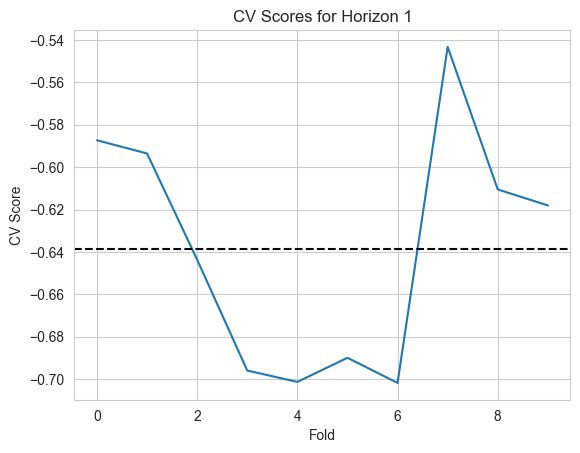

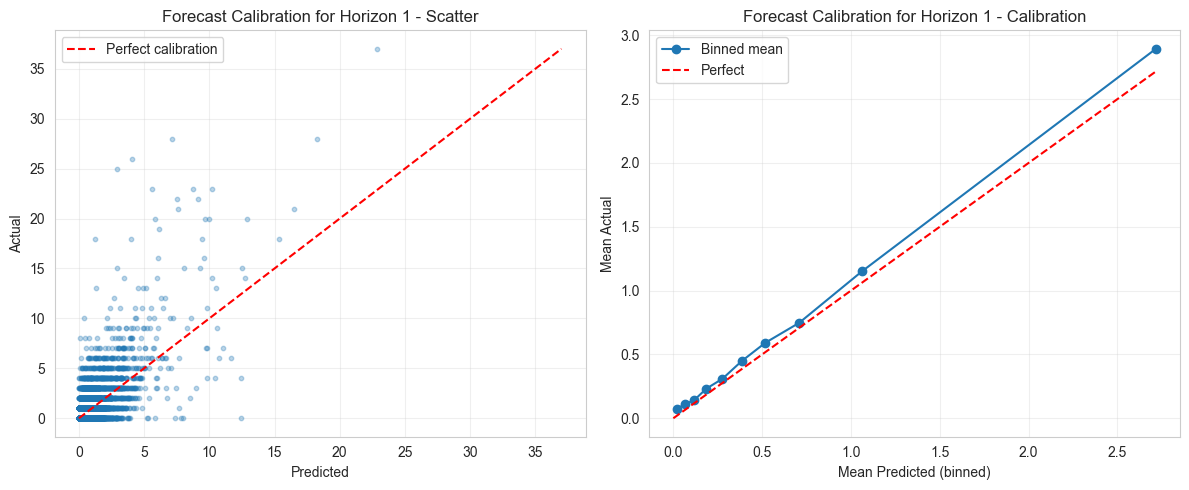

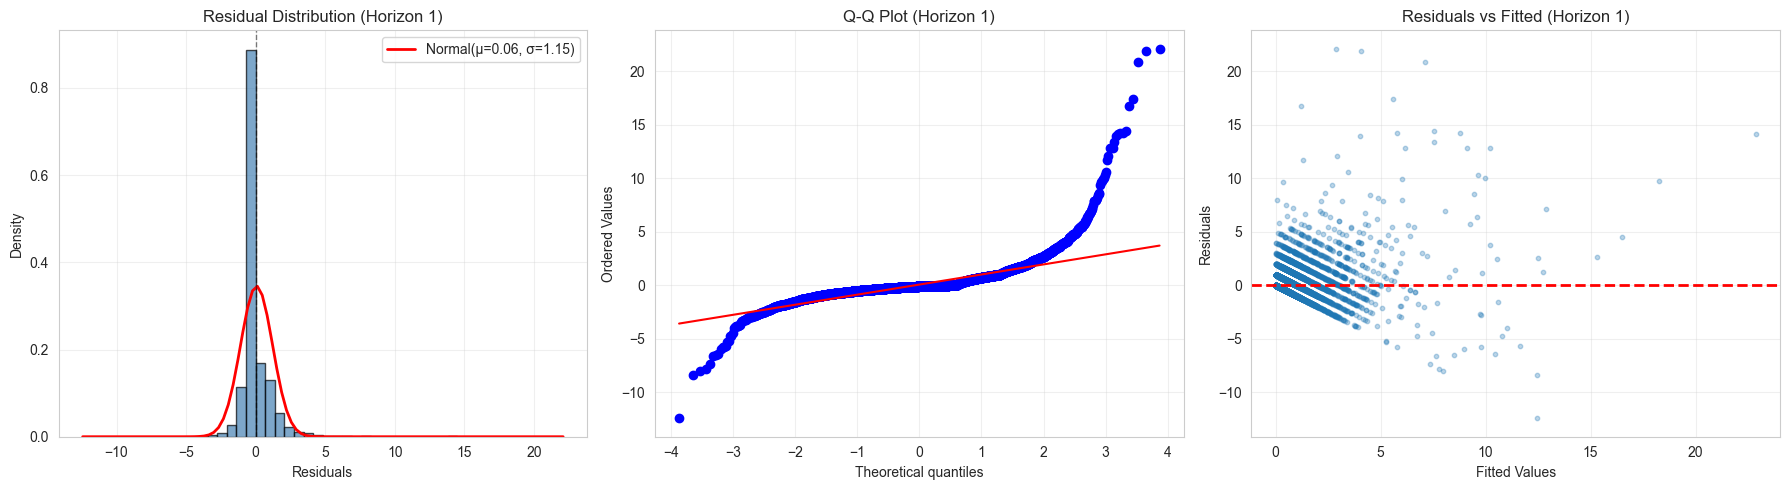


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.0643
  Std Dev: 1.1548
  Median: -0.1091
  Skewness: 4.6156
  Kurtosis: 61.2514

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6587
  P-value: 4.1346e-72
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 953.2339
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 0.9892136317171131, 'mae': 0.620589315727949, 'poisson_deviance': 0.9870802256566378, 'n_samples': 411386}, 'test': {'horizon': 1, 'rmse': 1.1128450695904102, 'mae': 0.6130990141237332, 'poisson_deviance': 1.033719282503502, 'n_samples': 12601}}



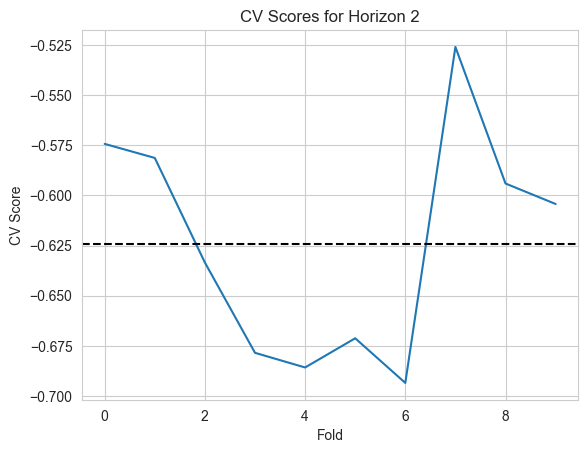

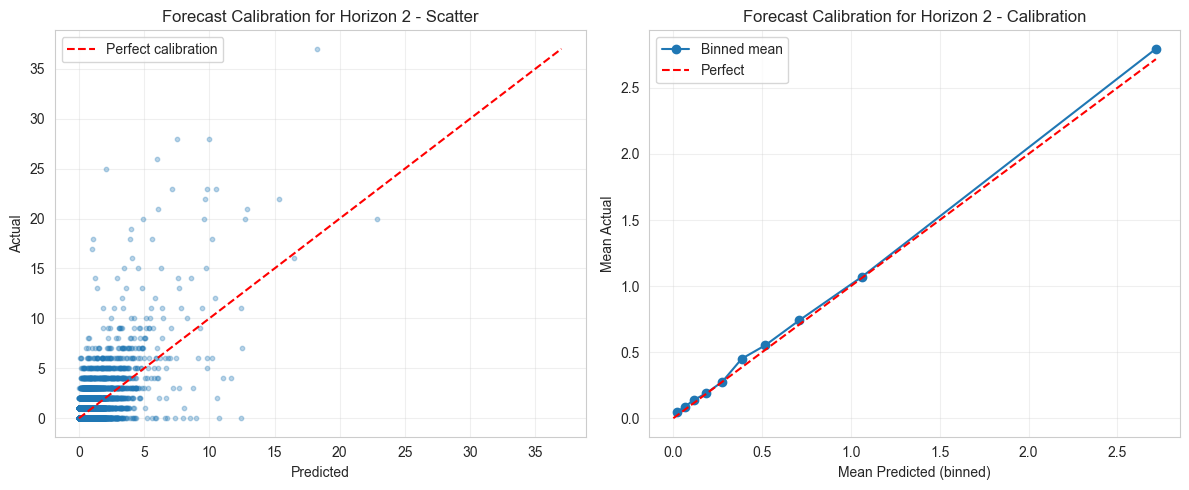

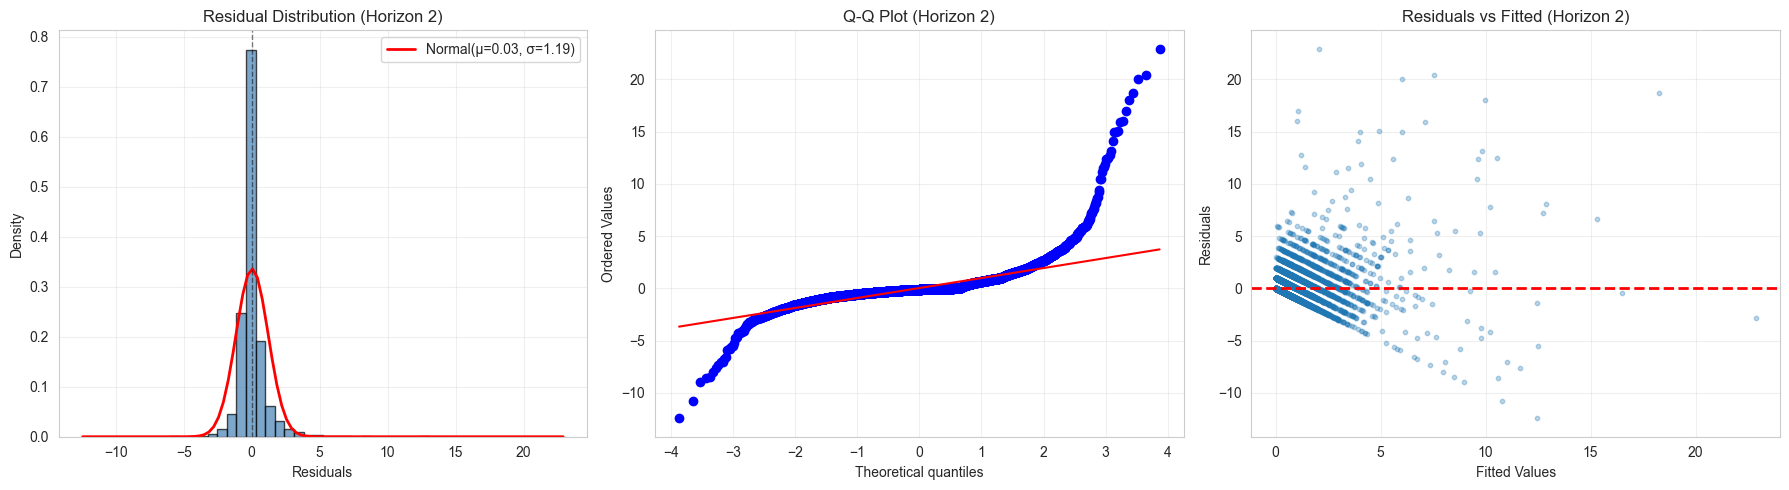


Horizon 2 - Residual Analysis
Residual Statistics:
  Mean: 0.0294
  Std Dev: 1.1889
  Median: -0.1165
  Skewness: 4.6578
  Kurtosis: 64.3282

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6854
  P-value: 1.8938e-70
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1015.7695
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 0.9817173211209579, 'mae': 0.6078177832584569, 'poisson_deviance': 0.9733826402941166, 'n_samples': 411386}, 'test': {'horizon': 1, 'rmse': 1.1996020105497576, 'mae': 0.6162743485748289, 'poisson_deviance': 1.0665335449384366, 'n_samples': 12601}}



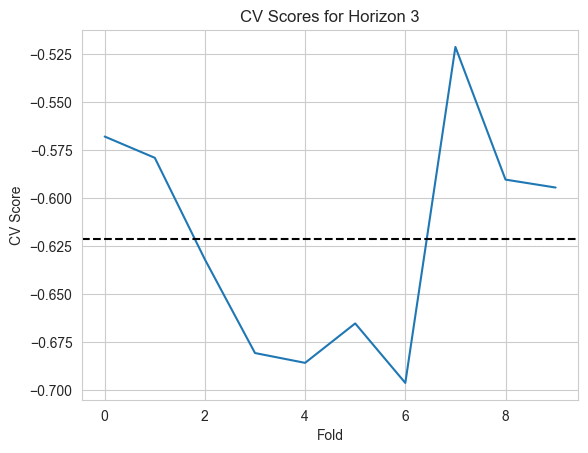

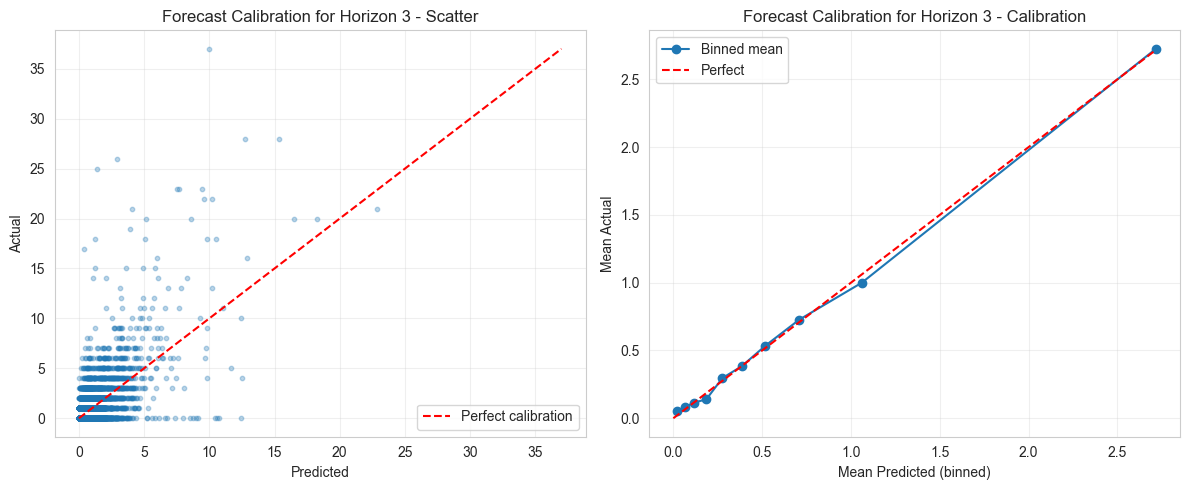

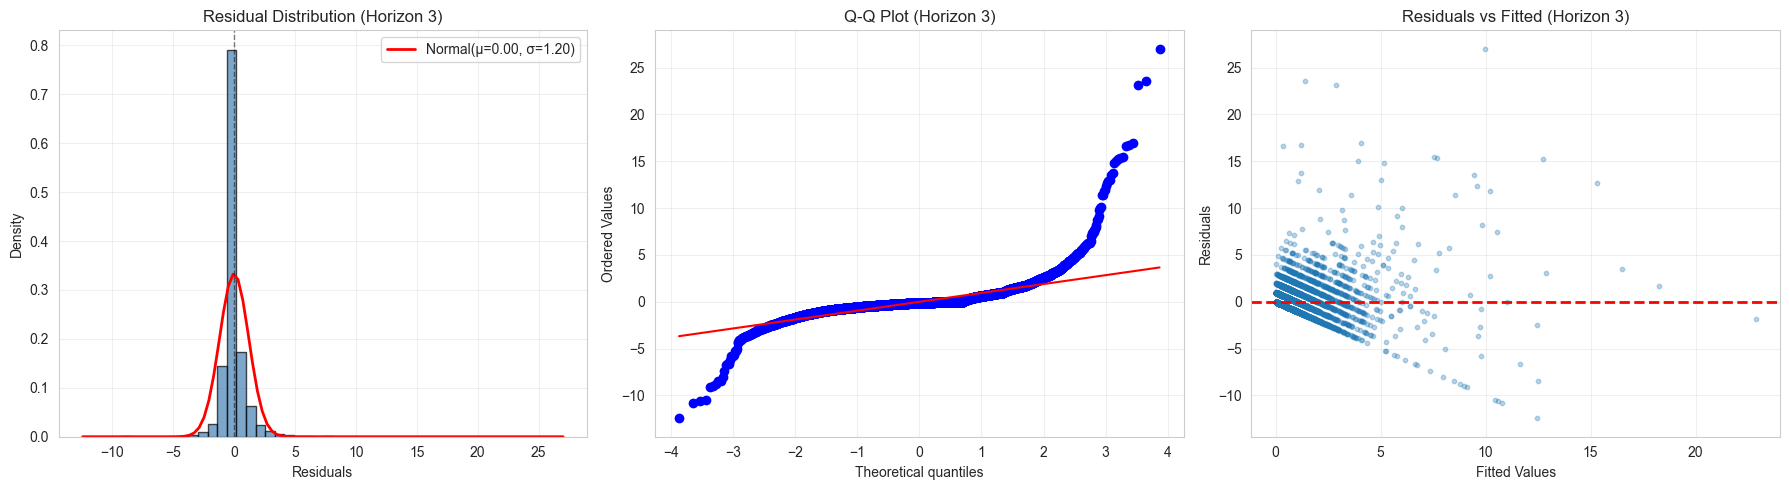


Horizon 3 - Residual Analysis
Residual Statistics:
  Mean: 0.0004
  Std Dev: 1.1978
  Median: -0.1262
  Skewness: 4.9945
  Kurtosis: 80.5564

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.5962
  P-value: 1.3525e-75
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1061.5802
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 0.9751065937014531, 'mae': 0.6020156839239603, 'poisson_deviance': 0.9683830379799675, 'n_samples': 411386}, 'test': {'horizon': 1, 'rmse': 1.2245009114627265, 'mae': 0.6073308685914999, 'poisson_deviance': 1.0770018686014298, 'n_samples': 12601}}



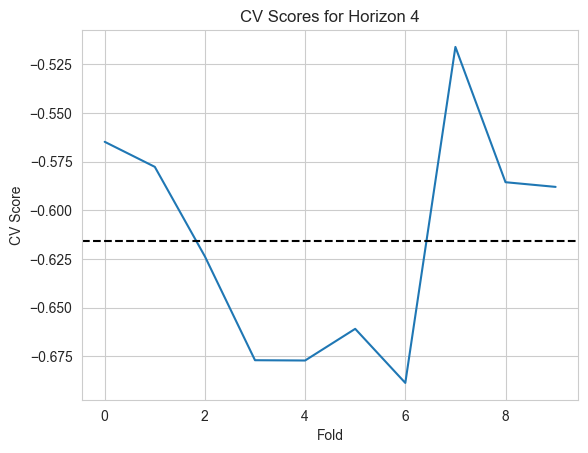

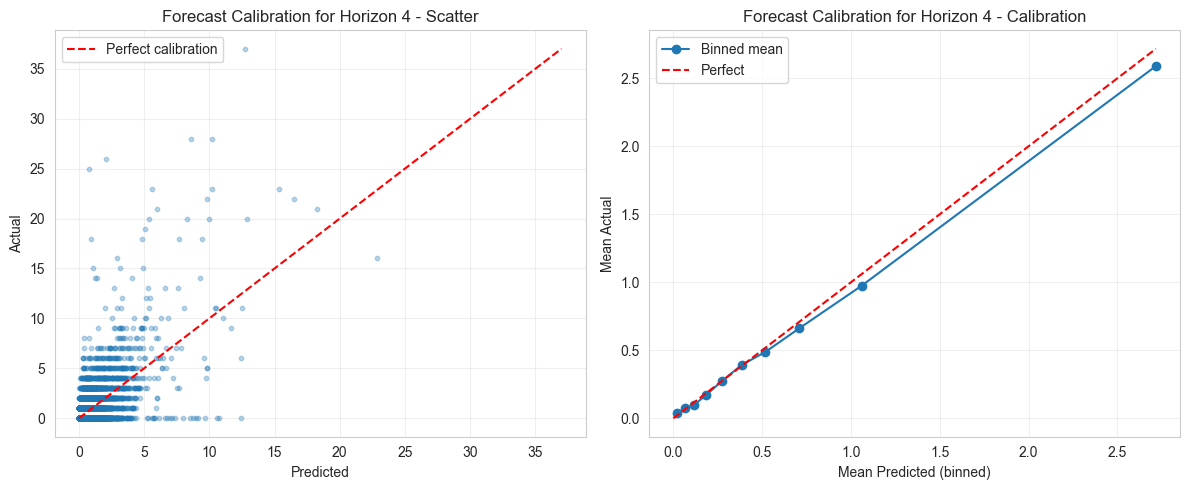

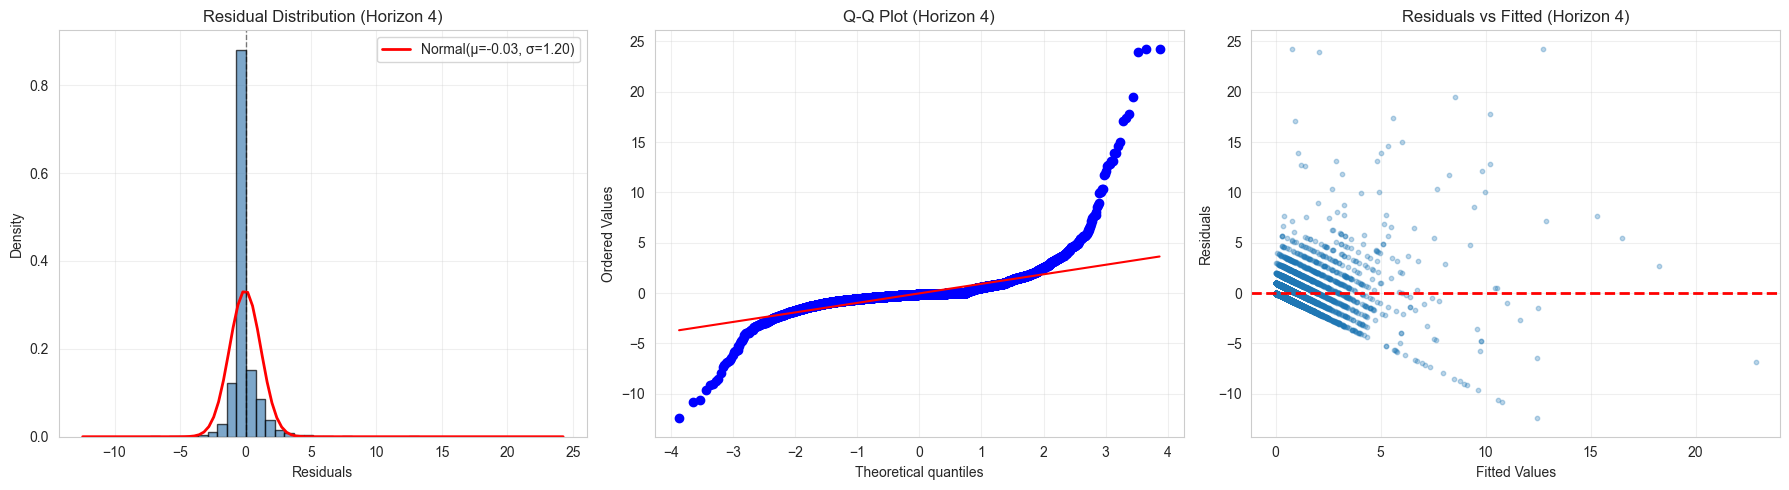


Horizon 4 - Residual Analysis
Residual Statistics:
  Mean: -0.0293
  Std Dev: 1.1977
  Median: -0.1333
  Skewness: 4.9113
  Kurtosis: 79.0575

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6571
  P-value: 3.3197e-72
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1080.9005
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 0.9763109106963428, 'mae': 0.5970442205928126, 'poisson_deviance': 0.9628375255017997, 'n_samples': 411386}, 'test': {'horizon': 1, 'rmse': 1.1980573401482082, 'mae': 0.6024987206455557, 'poisson_deviance': 1.0648724845595154, 'n_samples': 12601}}



In [ ]:
reload(forecast)
forecast.evaluate_models(bundle)

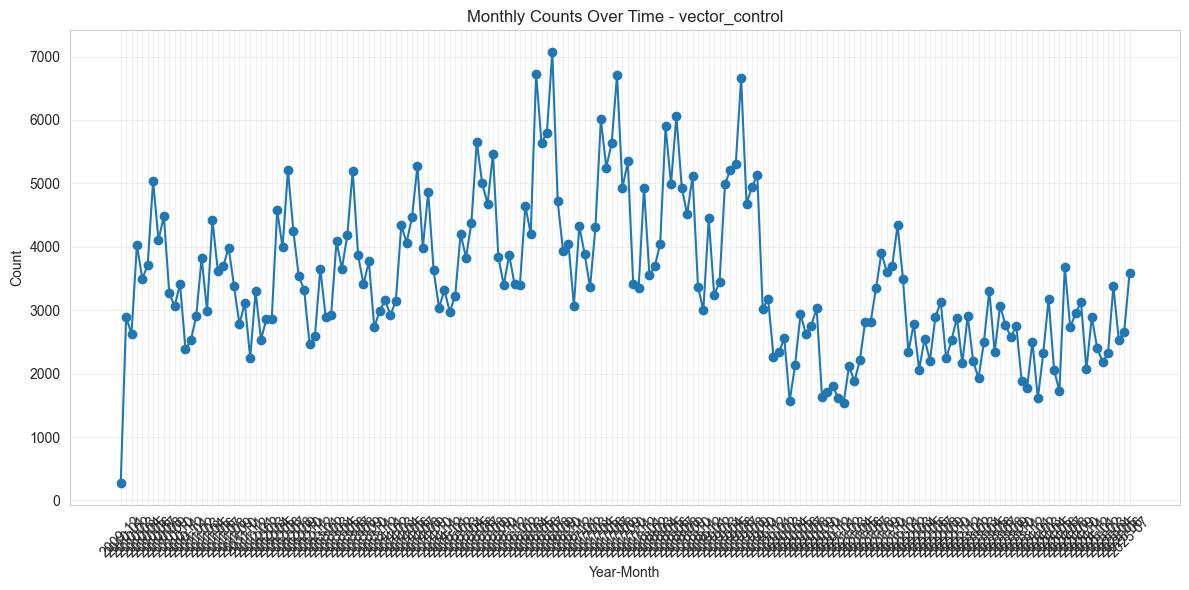

,year_month,y
0,2009-12,274.0
1,2010-01,2886.0
2,2010-02,2629.0
3,2010-03,4029.0
4,2010-04,3497.0
...,...,...
183,2025-03,2320.0
184,2025-04,3377.0
185,2025-05,2534.0
186,2025-06,2659.0


In [ ]:
# Plot counts over time by year-month
df_plot = forecast_panel[forecast_panel['week'] >= '2022-01-01'].copy()
df_plot = forecast_panel.copy()
df_plot['year_month'] = df_plot['week'].dt.to_period('M')
monthly_counts = df_plot.groupby('year_month')['y'].sum().reset_index()
monthly_counts['y_smoothed'] = monthly_counts.rolling(26).mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['year_month'].astype(str), monthly_counts['y'], marker='o')
plt.plot(monthly_counts['year_month'].astype(str), monthly_counts['y_smoothed'])

plt.title(f'Monthly Counts Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly_counts

In [ ]:
last_rows = panel.groupby(['hex', 'complaint_family']).last().reset_index()

# Predict 7 days ahead
predictions = forecast.predict_forecast(bundles, last_rows, horizon=7)

In [ ]:
last_rows

In [ ]:
predictions

In [ ]:
# triage_features, tfidf_matrix, vectorizer = features.build_triage_features(df)
# duration_labels = features.build_duration_survival_labels(df)
# duration_features = features.build_duration_features(df, triage_features)
